# Introduction

The following study is an introductory exploration of an automated decision model.  The primary aims of this analysis are to develop a deeper understanding of binary decision-making circumstances and how the use of ML models/algorithms can be used to assist and even automate this process.  This analysis takes on a realistic problem using simulated data.  Based on several characteristics of a potential borrower -- like their financial status, reasons for seeking a loan, and age -- is it wise or ill-advised to approve them for a given loan?  The sections below attempt to produce a reasonable answer to this question through the creation of an automated decision-making model.

The general methodologies for this study involve an initial exploration of the data, constructing a model using certain features, and determining an optimal threshold based on a defined scoring function.  It is necessary to observe some general patterns and trends present in the data before building a model.  After the preliminary visualization and preprocessing steps, an initial model will be constructed and further refined using an iterative feature selection process supported by cross-validation.  After an improved (by training accuracy) model is obtained, a scoring function will be defined using the weights determined by the best model version.  With this scoring function, an optimal threshold can then be examined and set to maximize desirable values such as model accuracy and bank profit.  Finally, with an optimal threshold selected and a refined model, the behavior of this model on unseen data can be evaluated.  Following the final model's evaluation this study concludes with a discussion of the implications behind automated decision algorithms with respect to general "fairness" from the perspective of all stakeholders (model designers, model users, and all impacted individuals, and etc.).

### Accessing the Data

In [175]:
# Includuing all additional imports
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

train = pd.read_csv("https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv")

*Including all additional imports*

The data used in this analysis is a [simulated data set](https://www.kaggle.com/datasets/laotse/credit-risk-dataset) of credit bureau data based on patterns observed in real credit bureau data.  

## Exploring the Data
### Preliminary Visualizations


In [176]:
# Data modification
train_viz = train.copy()
loan_status_recode = {0: "Paid in Full", 1: "Defaulted"}
loan_intent_recode = {"VENTURE": "Venture", "EDUCATION": "Education", "MEDICAL": "Medical", "HOMEIMPROVEMENT": "Home Improvement", "PERSONAL": "Personal",
 "DEBTCONSOLIDATION" : "Debt Consolidation"}
train_viz["loan_repayment"] = train_viz["loan_status"].map(loan_status_recode)
train_viz["loan_intent"] = train_viz["loan_intent"].map(loan_intent_recode)
train_viz.loc[train_viz["person_age"] >= 100, "person_age"] = None
train_viz = train_viz.dropna()

# Subsetting data by loan status
defaulted = train_viz[train_viz["loan_status"] == 1].copy().dropna()
repaid = train_viz[train_viz["loan_status"] == 0].copy().dropna()

*Modifying training data for visualization*

In [177]:
# Creating linear regression models and calculating R^2 values
## Defaulted
c1 = np.polyfit(defaulted["loan_amnt"], defaulted["person_income"], 1)
p1 = np.polyval(c1, defaulted["loan_amnt"])
r1 = defaulted["person_income"] - p1
ssr1 = np.sum(r1 ** 2)
sst1 = np.sum((defaulted["person_income"] - np.mean(defaulted["loan_amnt"])) ** 2)
rs1 = 1 - (ssr1 / sst1)

## Repaid
c2 = np.polyfit(repaid["loan_amnt"], repaid["person_income"], 1)
p2 = np.polyval(c2, repaid["loan_amnt"])
r2 = repaid["person_income"] - p2
ssr2 = np.sum(r2**2)
sst2 = np.sum((repaid["person_income"] - np.mean(repaid["loan_amnt"]))**2)
rs2 = 1 - (ssr2 / sst2)

*Creating linear regression models and calculating R^2 values for subsets of defaulted and fully repaid loans*

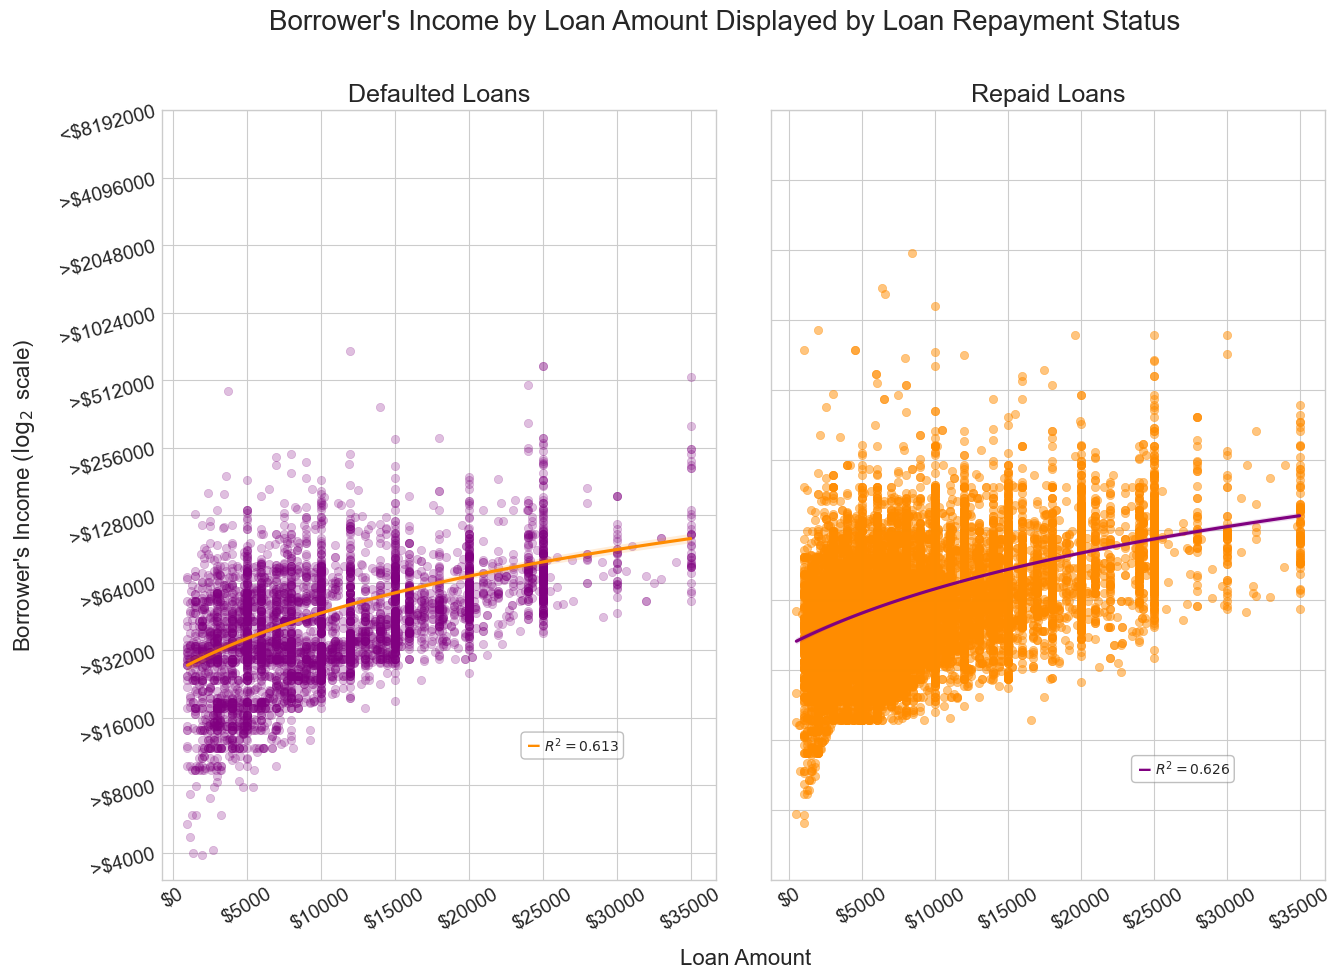

In [178]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
plt.style.use("seaborn-v0_8-whitegrid")

# Scatterplot and regression line for borrower income by loan amount of defaulted loans
ax[0] = sns.scatterplot(data = defaulted, x = "loan_amnt", y = "person_income", color = "purple", edgecolor = "purple", alpha = 0.25, ax = ax[0])
sns.regplot(data = defaulted, x = "loan_amnt", y = "person_income", scatter = False, line_kws={"color": "darkorange"}, ax = ax[0])
ax[0].set_yscale("log", base = 2)
ax[0].set_xlabel("")
ax[0].set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
ax[0].set_xticklabels(["$0", "$5000", "$10000", "$15000", "$20000", "$25000", "$30000", "$35000"], rotation = 30, fontsize = 14)
ax[0].set_ylabel(f"Borrower\'s Income ($\log_2$ scale)", fontsize = 16, labelpad = 15)
ax[0].set_yticks([2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21, 2**22, 2**23])
ax[0].set_yticklabels([">$4000", ">$8000", ">$16000", ">$32000", ">$64000", ">$128000", ">$256000", ">$512000", ">$1024000", ">$2048000", ">$4096000", "<$8192000"], rotation = 15, fontsize = 14)
ax[0].set_title("Defaulted Loans", fontsize = 18)
ax[0].text(27000, 12288, f"     $R^2 = {rs1:.3f}$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0].text(24000, 12288, "\u2013", color = "darkorange", ha = "left", va = "center", fontsize = 15, fontweight = "bold")

# Scatterplot and regression line for borrower income by loan amount of repaid loans
ax[1] = sns.scatterplot(data = repaid, x = "loan_amnt", y = "person_income", color = "darkorange", edgecolor = "darkorange", alpha = 0.5, ax = ax[1])
sns.regplot(data = repaid, x = "loan_amnt", y = "person_income", scatter = False, line_kws={"color": "purple"}, ax = ax[1])
ax[1].set_yscale("log", base = 2)
ax[1].set_xlabel("")
ax[1].set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
ax[1].set_xticklabels(["$0", "$5000", "$10000", "$15000", "$20000", "$25000", "$30000", "$35000"], rotation=30, fontsize = 14)
ax[1].set_ylabel("")
ax[1].set_yticks([2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21, 2**22, 2**23])
ax[1].set_yticklabels(12 * [""], rotation = 15)
ax[1].set_title("Repaid Loans", fontsize = 18)
ax[1].text(27000, 12288, f"     $R^2 = {rs2:.3f}$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[1].text(24000, 12288, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight = "bold")

fig.suptitle("Borrower\'s Income by Loan Amount Displayed by Loan Repayment Status", fontsize = 20)
fig.text(0.47, 0.025, "Loan Amount", fontsize = 16)
plt.subplots_adjust(wspace = 0.1)

**Figure 1**

The plots above display the relationship between a borrower's income and the loan amount borrowed for both defaulted and fully repaid loans.  To assist the visualization of the data points, the dependent variable `person_income` is adjusted using a $\log_2$ scale.  With this scale in place and for both defaulted and fully repaid loans, there appears to be a transformed linear relationship between a borrower's income and the loan amount borrowed.  Additionally, this transformed linear relationship appears to be positive and moderately strong (given both $R^2$ values > 0.6).  For both borrowers who defaulted on loans and borrowers who fully repaid their loans, it appears that as the loan amount increases, a borrower's income increases (adjusted by a $\log_2$ scale).  Considering this observed relationship, it is reasonable to assert that bigger loans are borrowed by individuals with higher income levels, regardless of whether or not those individuals defaulted or fully repaid their loans. 

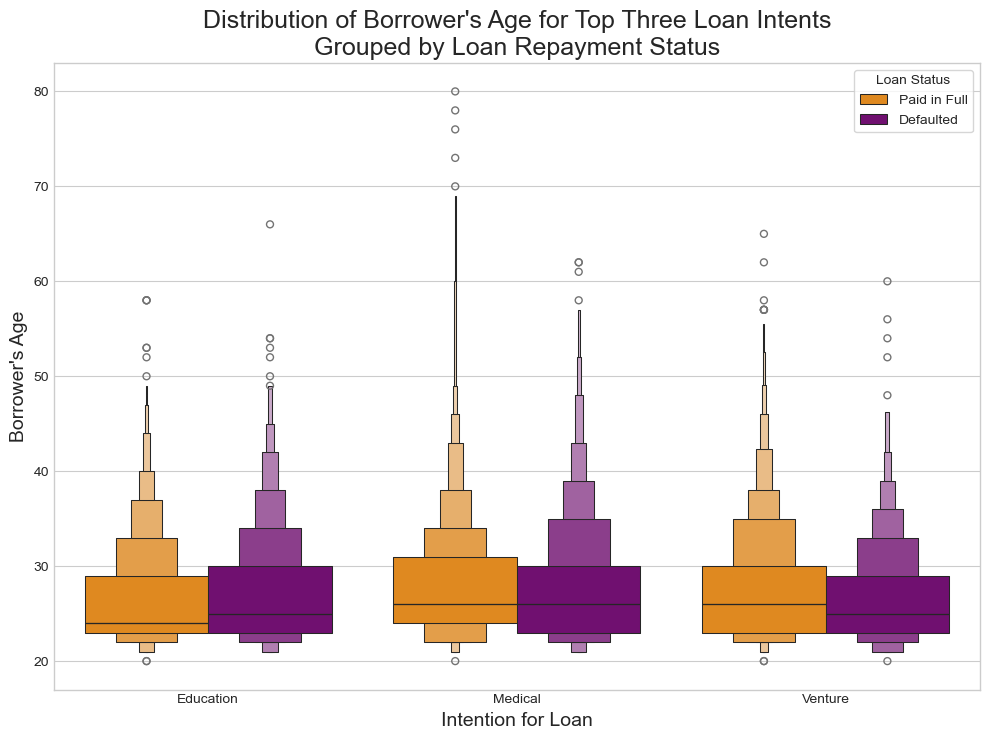

In [179]:
# Subsetting data to the three most common loan intents
common_loan_intents = train_viz.copy()
common_loan_intents = train_viz[train_viz["loan_intent"].isin(["Education", "Medical", "Venture"])].copy()

# Creating Boxen Plot
fig, ax = plt.subplots(1, 1, figsize = (10, 7.5))
plt.style.use("seaborn-v0_8-whitegrid")

p = sns.boxenplot(common_loan_intents, x = "loan_intent", y = "person_age", hue = "loan_repayment", palette = ["darkorange", "purple"])
p.set_xlabel("Intention for Loan", fontsize = 14)
p.set_ylabel("Borrower\'s Age", fontsize = 14)
p.set_xticks(["Education", "Medical", "Venture"])
p.legend(title = "Loan Status", frameon = True)
p.set_title("Distribution of Borrower\'s Age for Top Three Loan Intents\nGrouped by Loan Repayment Status", fontsize = 18)
plt.tight_layout()

**Figure 2**

The figure above shows an `sns.boxenplot` displaying the distribution of borrower's age for the three most common loan intents across both defaulted and fully repaid loans.  

<u>For education loans:</u> The median age of both borrowers who defaulted on loans and borrowers who fully repaid their loans is less than or equal to that of defaulting and repaying borrowers taking out medical and venture loans.  Additionally, the median age of educational loan borrowers is lower for those who fully repaid their loans than it is for those who defaulted -- Thus, a topic for another analysis could be to explore how the age of educational loan borrowers has an impact on such loans being repaid.

<u>For medical loans:</u> It appears that the median age of borrowers is greater than those taking out loans for education or venture.  There is also very little visually observable difference in the median age of borrowers who defaulted and borrowers who fully repaid their medical loans.  

<u>For venture loans:</u> The median age of borrowers who fully repaid their loans is greater than that of those who defaulted on their loans.  Similarly to the topic posed for educational loan borrowers, it could be interesting to explore in a future study how the age of venture loan borrowers has an effect on such loans being repaid.

### Table of General Summary Statistics

In [180]:
# Summary Statistics

# Helper method to calculate coefficient of variation (%)
def cv(col):
    return (col.std() / col.mean()) * 100

# Creating a table grouped by penguin species and sex, showing general summary stats for several quantitative variables
sum_stats = train_viz.rename(columns = {"loan_repayment": "Loan Repayment", "loan_amnt": "Loan Amount", "person_income": "Borrower\'s Income", "loan_intent": "Loan Intent", "person_age": "Borrower\'s Age", "loan_percent_income": "Loan Percent Income"}).copy()
sum_stats = sum_stats.groupby(["Loan Repayment", "Loan Intent"]).aggregate({"Loan Amount" : ["mean", "std", cv], 
                                                             "Borrower\'s Income" : ["mean", "std", cv], "Loan Percent Income": ["mean", "std", cv], 
                                                             "Borrower\'s Age": ["mean", "std", cv]})
sum_stats = sum_stats.rename(columns = {"mean": "Mean", "std": "STD", "cv": "CV (%)"})
sum_stats = sum_stats.round(2)
sum_stats

Loan Amount                  \
                                         Mean      STD CV (%)   
Loan Repayment Loan Intent                                      
Defaulted      Debt Consolidation    11283.45  7357.29  65.20   
               Education             10912.82  6979.08  63.95   
               Home Improvement      10035.04  7324.85  72.99   
               Medical               11438.49  7190.60  62.86   
               Personal              10459.89  6884.86  65.82   
               Venture               11115.68  6695.34  60.23   
Paid in Full   Debt Consolidation     9050.14  5810.33  64.20   
               Education              9206.44  6010.44  65.29   
               Home Improvement      10518.51  6398.11  60.83   
               Medical                8570.88  5645.54  65.87   
               Personal               9441.60  6133.81  64.97   
               Venture                9307.47  6064.40  65.16   

                                  Borrower's Income                   \
                                               Mean       STD CV (%)   
Loan Repayment Loan Intent                                             
Defaulted      Debt Consolidation          54553.15  37624.33  68.97   
               Education                   47283.67  30264.34  64.01   
               Home Improvement            49794.13  33062.93  66.40   
               Medical                     52477.12  44092.21  84.02   
               Personal                    46965.14  39080.81  83.21   
               Venture                     44439.34  27743.83  62.43   
Paid in Full   Debt Consolidation          72388.92  61644.36  85.16   
               Education                   67866.15  41045.51  60.48   
               Home Improvement            82499.92  50452.00  61.15   
               Medical                     65116.70  51476.94  79.05   
               Personal                    72343.94  54121.45  74.81   
               Venture                     70493.68  58762.60  83.36   

                                  Loan Percent Income               \
                                                 Mean   STD CV (%)   
Loan Repayment Loan Intent                                           
Defaulted      Debt Consolidation                0.24  0.13  57.00   
               Education                         0.26  0.13  51.90   
               Home Improvement                  0.22  0.13  57.24   
               Medical                           0.24  0.13  54.74   
               Personal                          0.25  0.13  51.99   
               Venture                           0.28  0.13  47.39   
Paid in Full   Debt Consolidation                0.14  0.08  58.11   
               Education                         0.15  0.09  57.71   
               Home Improvement                  0.14  0.09  61.15   
               Medical                           0.15  0.08  56.46   
               Personal                          0.15  0.09  57.83   
               Venture                           0.15  0.09  59.45   

                                  Borrower's Age               
                                            Mean   STD CV (%)  
Loan Repayment Loan Intent                                     
Defaulted      Debt Consolidation          27.76  6.52  23.49  
               Education                   27.09  6.10  22.50  
               Home Improvement            27.62  6.04  21.86  
               Medical                     27.70  6.31  22.78  
               Personal                    27.24  6.09  22.37  
               Venture                     26.74  5.45  20.38  
Paid in Full   Debt Consolidation          27.54  5.66  20.56  
               Education                   26.43  5.49  20.79  
               Home Improvement            29.47  5.48  18.60  
               Medical                     27.96  6.17  22.07  
               Personal                    28.49  7.42  26.03  
               Venture        

*In creating the table above, I did some [brief research](https://www.investopedia.com/terms/c/coefficientofvariation.asp#toc-coefficient-of-variation-cv-vs-standard-deviation) on CV to more easily interpret the STD and wrote the helper method*

**Table 1**

The table above presents some general summary statistics from the data.  I was interested in examining the mean, STD, and CV for some of the primary quantitative features in the data (`loan_amnt`, `person_income`, `loan_percent_income`, `person_age`) across each loan intent for both defaulted and fully repaid loans.

<u>For Defaulted Loans:</u> 

-   Medical loans are greatest in size on average compared to the other loan intents.
    -   Home Improvement loans are the smallest in size on average.
-   Debt Consolidation loans are taken out by borrowers with the greatest average income.
    -   Venture loans are taken out by borrowers with the smallest average income.
-   Venture loans have the largest average loan-value-percent-income in borrowers
    -   Home improvement loans have the smallest average loan-value-percent-income among borrowers
-   Debt Consolidation loans are taken out by borrowers with the largest age on average.
    -   Venture loans correspond to borrowers with the lowest age on average.

<u>For Fully Repaid Loans:</u> 

-   Home Improvement loans are greatest in size on average compared to the other loan intents.
    -   Medical loans are the smallest in size on average. (Interestingly, this is the complete opposite of defaulted loans)
-   Home Improvement loans are taken out by borrowers with the greatest average income.
    -   Medical loans are taken out by borrowers with the smallest average income.
-   Medical, venture, education, and personal loans share the largest average loan-value-percent-income in borrowers while home improvement and debt consolidation loans correspond to the smallest average loan-value-percent-income in borrowers.

In terms of the spread of data across the variables displayed in the table, all four features possess relatively high coefficient of variation (CV%) values.  This suggests that there is a notable degree of variability in the distribution of each of these features.  However, some features appear to vary more than others: `Loan Amount`, `Borrower's Income`, and `Loan Percent Income` all have average CV (%) values > 50% while `Borrower's Age` has an average CV (%) $\approx$ 20%.  Additionally, there appears to be no considerable difference in CV (%) across each of the recorded loan intents nor between defaulted and fully repaid loans in general.

# Model Construction
## Feature Selection


In [181]:
# Modifying the training data
X = train.drop(["loan_status", "loan_grade"], axis = 1, errors = "ignore")
y = train["loan_status"]

# Creating one-hot encodings for qualitative variables
X = pd.get_dummies(X, drop_first = True)

# Removing NAs from data while maintaining alignment
clean = pd.concat([X, y], axis = 1)
clean = clean.dropna()
X_train = clean.drop("loan_status", axis = 1, errors = "ignore").copy()
y_train = clean["loan_status"].copy()

# Adding new columns to X_train
## Ratio of employment length to credit history
X_train["credit_hist_emp_len"] =  X_train["person_emp_length"] / X_train["cb_person_cred_hist_length"]

# Identifying quantitative and qualitative variables in the data
quant_vars = [
              "person_age", 
              "person_income", 
              "person_emp_length", 
              "loan_amnt", 
              "loan_int_rate", 
              "loan_percent_income", 
              "cb_person_cred_hist_length",
              "credit_hist_emp_len"
            ]
qual_vars = [
              "person_home_ownership_OTHER",
              "person_home_ownership_OWN",
              "person_home_ownership_RENT",
              "loan_intent_EDUCATION",
              "loan_intent_HOMEIMPROVEMENT",
              "loan_intent_MEDICAL",
              "loan_intent_PERSONAL",
              "loan_intent_VENTURE",
              "cb_person_default_on_file_Y"
            ]

# Combination of selected quant and qual variables
cols = quant_vars + qual_vars

# Toggle to run feature selection process
if (False):

  # Iterating through all possible subsets of cols, evaluating a model with each subset, to determine the optimal set of variables to use
  best_vars = []
  best_avg_score = 0

  # Paramters to determine the size of tested subsets
  lower_bound = 4
  upper_bound = 5
  for i in range(lower_bound, upper_bound):
      
      # Iterating through all subsets
      for subset in itertools.combinations(cols, i):
        curr_vars = list(subset)
        # Fitting a model to each subset
        LR = LogisticRegression(random_state = 69)
        LR.fit(X_train[curr_vars], y_train)
        curr_avg_score = cross_val_score(LR, X_train[curr_vars], y_train, cv = 5).mean()
        
        # Update the best average score and the best variables to use for the model
        if (curr_avg_score > best_avg_score):
          best_avg_score = curr_avg_score
          best_vars = curr_vars

# These are the best 5 variables selected after the iterative feature selection process above
best_vars = ["loan_percent_income", "cb_person_cred_hist_length", "person_home_ownership_OTHER", "person_home_ownership_RENT", "loan_intent_HOMEIMPROVEMENT"]

# Refined model
LR = LogisticRegression(random_state = 69)
LR.fit(X_train[best_vars], y_train)
score = LR.score(X_train[best_vars], y_train)
print(f"Refined Model Accuracy: {score * 100: .3f}%")

# Setting the weights vector
w = np.array(LR.coef_[0])

Refined Model Accuracy:  85.096%


*Code above shows the iterative process of trying all combinations of certain sizes for all features and taking those that lead to the best cross-validated model performance*

To begin the feature selection process, the training data was informally divided into its quantitative and qualitative variables.  The feature selection process involved iterating through a subset of the power set (all possible subsets) of the training data.  All combinations of 1 up to 5 (out of 17) features were evaluated (beyond 5 features was too computationally expensive).  According to the feature selection above, the 5 best variables to train the model with are `loan_percent_income`, `cb_person_cred_hist_length` (length of borrower's credit history), `person_home_ownership_OTHER` (borrowers with home ownership status as "OTHER"), `person_home_ownership_RENT` (borrowers who are renting a home), and `loan_intent_HOMEIMPROVEMENT` (borrowers who intend to use a loan for home improvement).  With these features used, the `LogisticRegression` model achieved just over $85\%$ training accuracy.  While there is certainly room to improve the model's training accuracy, this is the highest score achieved using the variables provided by the data and without undertaking a massive computational load (i.e. super long run time to iterate through all elements of the variable power set).  The weights used by the model were extracted and stored in a weights vector `w` to be used in the scoring function described below.

## Creating a Scoring Function



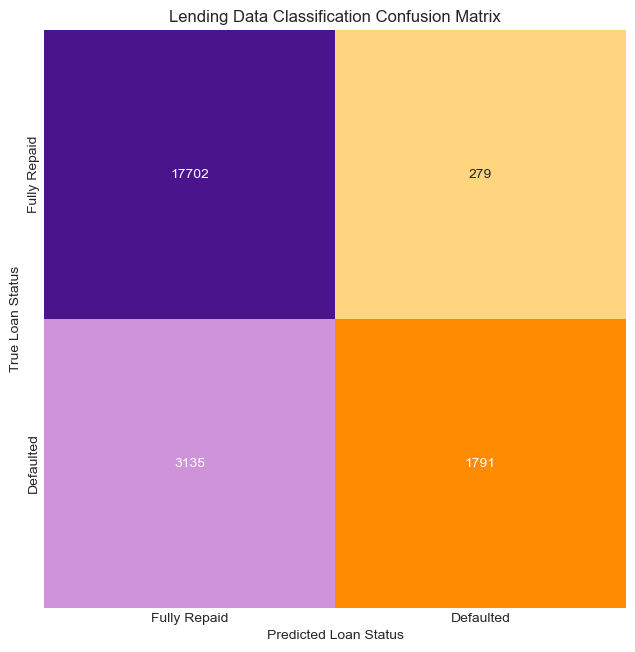

There were 17702 fully repaid loan(s) that were predicted to be fully repaid.
There were 279 fully repaid loan(s) that were predicted to be defaulted.
There were 3135 defaulted loan(s) that were predicted to be fully repaid.
There were 1791 defaulted loan(s) that were predicted to be defaulted.


In [182]:
# Function to compute the score for each observation
def lin_score(X, w):
    return X@w

# Computing scores of each training observation and observing confusion matrix for the training data
scores = lin_score(X_train[best_vars], w)

# Normalizing the scores
scores = (scores - scores.min()) / (scores.max() - scores.min())

# Observing confusion matrix for the training data
LR_pred = LR.predict(X_train[best_vars])
C = confusion_matrix(y_train, LR_pred)

# Establishing model predictions for the train data
y_train_pred = LR.predict(X_train[best_vars])
C = confusion_matrix(y_train, y_train_pred)
loan_status = ["Fully Repaid", "Defaulted"]

# Creating a heatmap for better confusion matrix visualization
fig, ax = plt.subplots(1, 1, figsize = (7.5, 7.5))
mask1 = np.zeros_like(C, dtype=bool)
mask1[:, 1] = True
mask2 = np.zeros_like(C, dtype=bool)
mask2[:, 0] = True
purples = LinearSegmentedColormap.from_list("purple_gradient", ["#ce93d8", "#4a148c"])
darkoranges = LinearSegmentedColormap.from_list("darkorange_gradient", ["#FFD580", "darkorange"])
# Plot the first column with purple gradient
ax1 = sns.heatmap(C, annot=True, fmt="d", cmap=purples, 
                mask=mask1, cbar=False, xticklabels=["Fully Repaid", "Defaulted"],
                yticklabels=loan_status)

# Plot the second column with orange gradient
ax2 = sns.heatmap(C, annot=True, fmt="d", cmap=darkoranges, 
                mask=mask2, cbar=False, xticklabels=["Fully Repaid", "Defaulted"],
                yticklabels=loan_status)

# Setting labels and title
plt.xlabel("Predicted Loan Status")
plt.ylabel("True Loan Status")
plt.title("Lending Data Classification Confusion Matrix")

plt.show()

# Printing confusion matrix results
print(f"There were {C[0, 0]} fully repaid loan(s) that were predicted to be fully repaid.")
print(f"There were {C[0, 1]} fully repaid loan(s) that were predicted to be defaulted.")
print(f"There were {C[1, 0]} defaulted loan(s) that were predicted to be fully repaid.")
print(f"There were {C[1, 1]} defaulted loan(s) that were predicted to be defaulted.")

*Code above shows the linear scoring function used to determine model predictions and evaluate model accuracy.  The scores were normalized to ensure that all scores are within the interval [0, 1]*

**Figure 3**

For this analysis, a linear scoring function is used.  Specifically, the linear scoring function computes the score of each data observation by taking the dot product of each observation with the weights vector `w`.  To ensure that all scores are values on the interval [0, 1], the scores are normalized after they are calculated (i.e. the scores are updated to be the difference between each raw score and the minimum raw score divided by the range of raw scores).  Additionally, the confusion matrix for the model's performance is displayed above.  The model's false positive rate is approximately $1.55\%$ while the true positive rate is approximately $36.34\%$.  Conversely, the model's false negative rate is approximately $63.66\%$ while the true negative rate is approximately $98.45\%$.  With this information, it appears that the model rarely misclassifies fully repaid loans as defaulted (low FPR).  However, the model frequently (moderately high FNR) misclassifies defaulted loans as being fully repaid.  In general, with a very high TNR, the model is very accurate at detecting truly fully repaid loans but much less accurate (low TPR) at recognizing truly defaulted loans.  It is important to note here that the initial objective for this model was to accurately predict if a prospective borrower will default on a loan, thus suggesting that perhaps the model and or the scoring function should be slightly redesigned to increase the TPR.  However, given the introductory nature of this brief study, the analysis will continue with the current model as is.

### Plotting Distribution of Scores

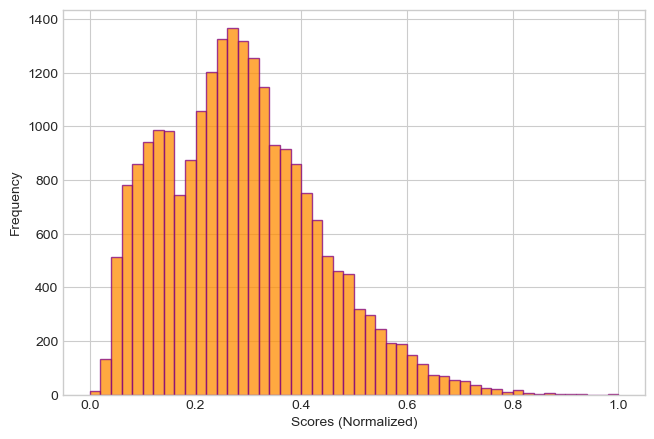

In [183]:
# Distribution of Scores - Code Provided by Prof. Chodrow
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
plt.style.use("seaborn-v0_8-whitegrid")
hist = ax.hist(scores, bins = 50, color = "darkorange", alpha = 0.75, linewidth = 1, edgecolor = "purple")
labs = ax.set(xlabel = r"Scores (Normalized)", ylabel = "Frequency") 

# Percentage (the majority) of scores below 0.5
maj_scores = (scores <= 0.5).mean()

**Figure 4**

As observed in the distribution of normalized scores above, it appears that the strong majority ($\approx 91.81\%$)of normalized scores are less than or equal to 0.5.  This may indicate that a useful threshold value for maximizing model accuracy and or bank profit per borrower (as informed by the model) might be close to $t = 0.5$.

## Choosing a Threshold

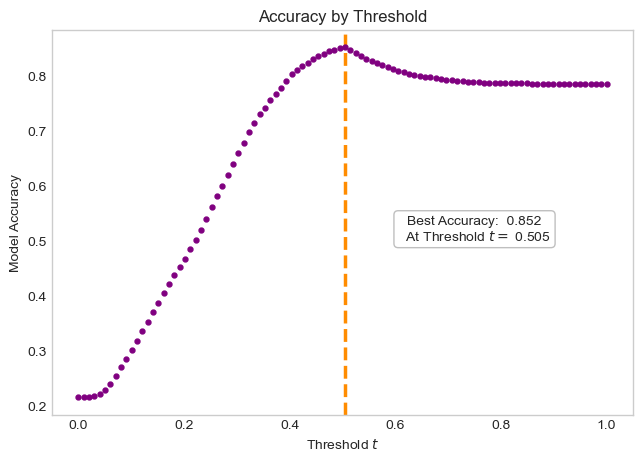

In [184]:
# Threshold selection based on model accuracy
best_accuracy = 0
best_threshold = 0

# Following code is adapted from Prof. Chodrow
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
for t in np.linspace(0, 1, 100): 
    y_pred = scores >= t
    acc = (y_pred == y_train).mean()
    ax.scatter(t, acc, color = "purple", s = 12.5)
    if acc > best_accuracy: 
        best_accuracy = acc
        best_threshold = t
ax.axvline(best_threshold, linestyle = "--", color = "darkorange", linewidth = 2.5, zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Model Accuracy", title = "Accuracy by Threshold")
ax.text(0.75, 0.5, f"Best Accuracy: {best_accuracy: .3f}\n  At Threshold $t = ${best_threshold: .3f}", ha = "center",
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "grey", boxstyle = "round,pad=0.3"))
ax.grid(False)

**Figure 5**

Shown above is the trend in overall model accuracy as the threshold $t$ increases from $0: 1$.  As outlined in the plot, the peak model accuracy ($\approx 85\%$) is achieved using a threshold of $t = 0.505$.  However, what is likely more interesting (especially for the bank) is how the profit-per-borrower can be maximized through selecting a value for $t$.  Below is an examination of thresholding for profit maximization.

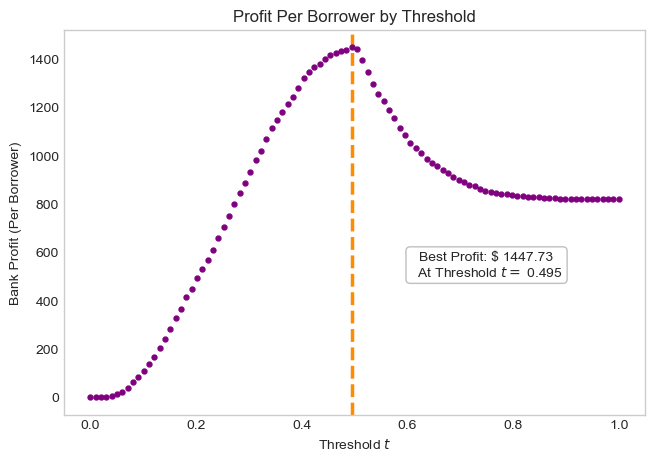

In [185]:
# Threshold selection based on profit for the bank created by the model

# Updated variables
best_ppb = 0
best_threshold = 0

# Following code is adapted from Prof. Chodrow
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))

for t in np.linspace(0, 1, 100): 
    y_pred = scores >= t
    
    # Determining whether each prediction is a a true or false negative to inform the amount of profit loss or gain for a given loan
    X_train["TN"] = ((y_pred == 0) & (y_train == 0)).astype(int)
    X_train["FN"] = ((y_pred == 0) & (y_train == 1)).astype(int)
    
    # Calculating the profit gain and loss for each borrower using the formulas provided by Prof. Chodrow
    profit_gain = X_train["TN"] * (X_train["loan_amnt"] * ((1 + (0.25 * (X_train["loan_int_rate"] / 100))) ** 10) - X_train["loan_amnt"])
    profit_loss = X_train["FN"] * (X_train["loan_amnt"] * ((1 + (0.25 * (X_train["loan_int_rate"] / 100))) ** 3) - (1.7 * X_train["loan_amnt"]))
    
    # Profit-per-borrower with the current threshold
    ppb = (profit_gain + profit_loss).sum() / X_train.shape[0]
    
    # Ploting PPB point and updating variables
    ax.scatter(t, ppb, color = "purple", s = 12.5)
    if ppb > best_ppb: 
        best_ppb = ppb
        best_threshold = t

# Plot styling
ax.axvline(best_threshold, linestyle = "--", color = "darkorange", linewidth = 2.5, zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Bank Profit (Per Borrower)", title = "Profit Per Borrower by Threshold")
ax.text(0.75, 500, f"Best Profit: ${best_ppb: .2f}\n  At Threshold $t = ${best_threshold: .3f}", ha = "center",
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "grey", boxstyle = "round,pad=0.3"))
ax.grid(False)

*In the code above, the bank's profit-per-borrower is plotted against the threshold $t$.  The profit per borrower is determined by calculating the profit gain and profit loss (using the formulas provided by Prof. Chordow) for each individual loan.   The correct profit value (either gain or loss) is then added to the overall profit sum depending on whether or not the model correctly classified a given loan as a true negative or incorrectly classified a given loan as a false negative.  The overall profit is then divided by the number of observations (borrowers) in the training data to yield the profit value per borrower.*

**Figure 6**

As depicted above, the bank's profit-per-borrower is shown to increase as the threshold $t$ increases before notably dropping and ultimately plateauing.  The bank's peak profit-per-borrower is approximately $\$1450.00$, corresponding to using a threshold value of $t = 0.495$.  Not surprisingly, both the model's overall accuracy as well as the bank's profit-per-borrower are maximized at very similar thresholds (about 0.5).

# Model Evaluation
## Perspective of the Bank


In [186]:
# Reading in and modifying the test data
test = pd.read_csv("https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv")
test = test.dropna()
Xt = test.drop(["loan_status", "loan_grade"], axis = 1, errors = "ignore")
yt = test["loan_status"]

# Creating one-hot encodings for qualitative variables
Xt = pd.get_dummies(Xt, drop_first = True)

# Removing NAs from data while maintaining alignment
clean = pd.concat([Xt, yt], axis = 1)
clean = clean.dropna()
X_test = clean.drop("loan_status", axis = 1, errors = "ignore").copy()
y_test = clean["loan_status"].copy()

# Computing and normalizing the test scores
test_scores = lin_score(X_test[best_vars], w)
# Normalizing the scores
test_scores = (test_scores - scores.min()) / (test_scores.max() - test_scores.min())

# Adding the model's calculated score for each observation in the testing data
test["score"] = test_scores
test["score"] = pd.to_numeric(test["score"], errors = "coerce")

# Determining predictions
y_test_pred = test_scores >= best_threshold

# Calculating the profit-per-borrower for test data (copied from code chunk above)
# Determining whether each prediction is a a true or false negative to inform the amount of profit loss or gain for a given loan
X_test["TN"] = ((y_test_pred == 0) & (y_test == 0)).astype(int)
X_test["FN"] = ((y_test_pred == 0) & (y_test == 1)).astype(int)

# Calculating the profit gain and loss for each borrower using the foromulas provided by Prof. Chodrow
profit_gain_t = X_test["TN"] * (X_test["loan_amnt"] * ((1 + (0.25 * (X_test["loan_int_rate"] / 100))) ** 10) - X_test["loan_amnt"])
profit_loss_t = X_test["FN"] * (X_test["loan_amnt"] * ((1 + (0.25 * (X_test["loan_int_rate"] / 100))) ** 3) - (1.7 * X_test["loan_amnt"]))

# Profit-per-borrower for test data using the best threshold
ppbt = (profit_gain_t + profit_loss_t).sum() / X_test.shape[0]

print(f"The Bank's Profit-Per-Borrower from the test data: ${ppbt :.2f}")
print(f"(Test Data PPB to Training Data PPB Ratio: {((ppbt / best_ppb) * 100): .2f}%)")

The Bank's Profit-Per-Borrower from the test data: $1326.67
(Test Data PPB to Training Data PPB Ratio:  91.64%)


*In the code above, the test data is processed the exact same way as the training data to ensure compatibility with the scoring function and profit-per-borrower calculations as previously done.*

According to the computation above, the bank's expected profit-per-borrower on the test data is approximately $\$1330.00$.  This value is roughly $92\%$ of (i.e. considerably similar to) the profit-per-borrower produced by the training data.  Consider the most popular loan intent from the test data: Educational loans.  According to the statistics provided by the [Education Data Initiative](https://educationdata.org/student-loan-debt-statistics#:~:text=Report%20Highlights.,borrowers%20have%20federal%20loan%20debt.), there were nearly 43 million student loan borrowers in the US in 2024.  Additionally, [MX Technologies](https://www.mx.com/blog/biggest-banks-by-asset-size-united-states/) reports there being about 4550 banks in the US.  If the number of US educational loan borrowers is divided amongst the number of US banks, each US bank could have approximately 9450 educational loan borrowers in 2024.  So suppose the hypothetical bank in this study has about 9450 educational loan borrowers.  Thus, the bank's profit (theoretically in 2024) from educational loans alone would be about $12.57 million.  This is of course a wildly crude calculation that is ultimately not based on any reviewed methodology.  But, it at least goes to show how large the hypothetical bank's annual profit theoretically could be, even for only one type of loan.

## Perspective of the Borrower
#### Loan Approval and Borrower Age

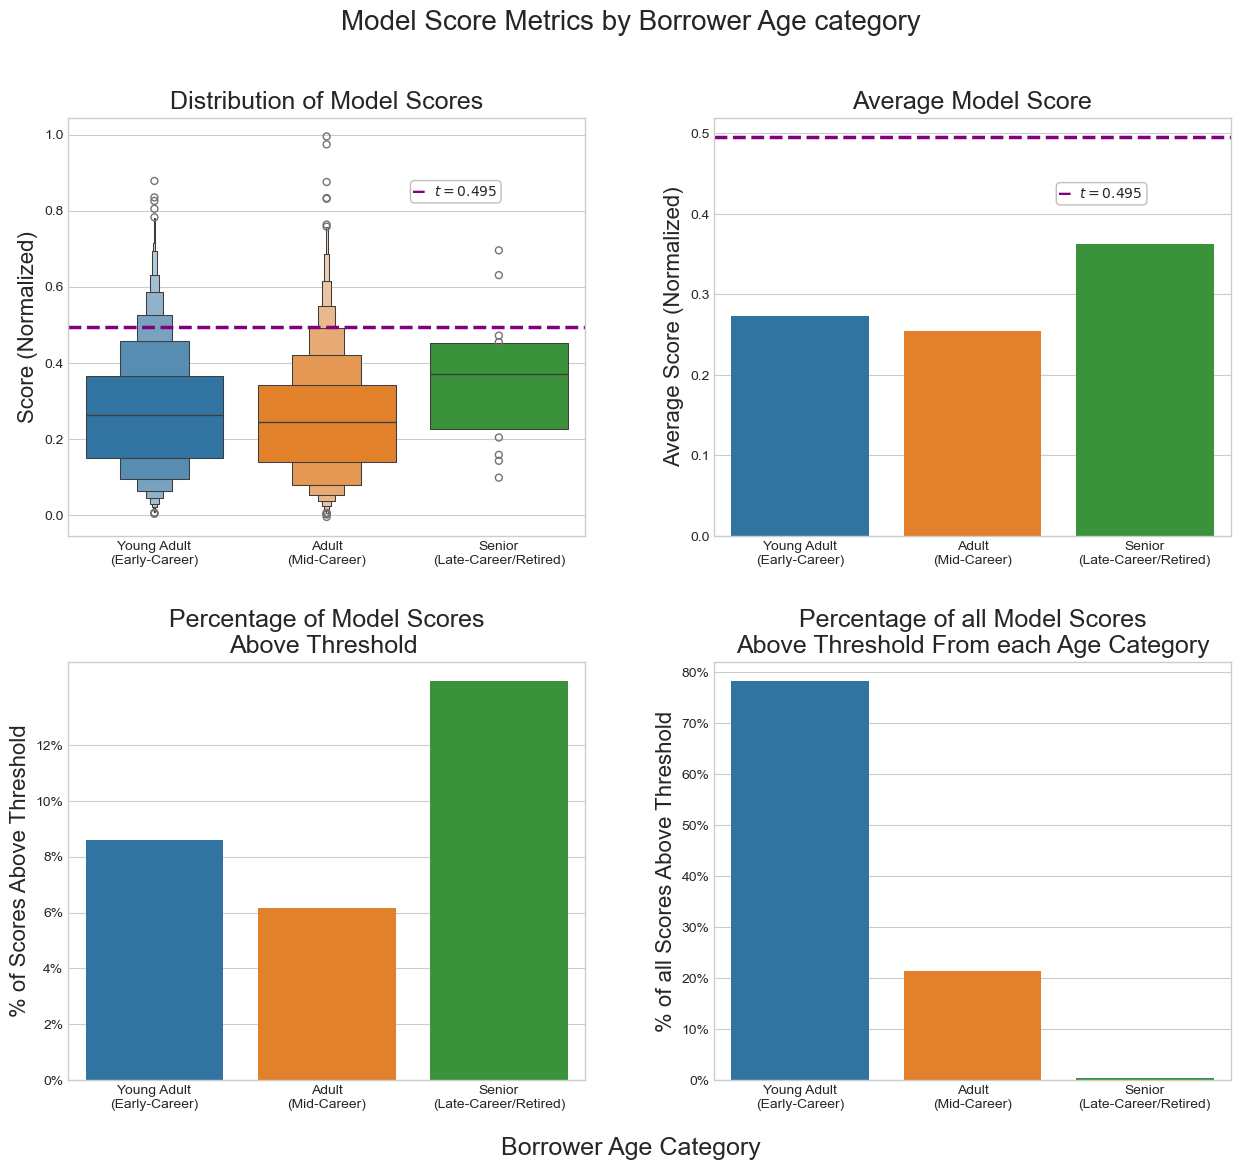

In [187]:
# Function to convert numerical ages to age categories
def age_cat(age):
    if (age < 30):
        return "Young Adult"
    elif (age < 60):
        return "Adult"
    else:
        return "Senior"

test["age_cat"] = test["person_age"].apply(age_cat)

# Independent and dependent variables for bar chart
age_cats = np.array(test["age_cat"].unique())

# Avg. scores calculated using .groupby(...).aggregate(...)
ac_avg_scores = np.array([
    test[test["age_cat"] == "Young Adult"]["score"].mean(),
    test[test["age_cat"] == "Adult"]["score"].mean(),
    test[test["age_cat"] == "Senior"]["score"].mean(),
    ])
age_scores_df = pd.DataFrame({"Age Cat": age_cats, "Avg Score": ac_avg_scores})

# Arrays of percentage of high scores and percentage of all scores above the threshold from each age cat
num_high_scores = (test["score"] >= best_threshold).sum()

# Perc. of high scores among each age cat
ac_perc_high_scores_1 = np.array([(test[test["age_cat"] == "Young Adult"]["score"] >= best_threshold).mean() * 100, 
                           (test[test["age_cat"] == "Adult"]["score"] >= best_threshold).mean() * 100, 
                           (test[test["age_cat"] == "Senior"]["score"] >= best_threshold).mean() * 100])

# Perc. of all high scores contributed by each age cat
ac_perc_high_scores_2 = np.array([(test[test["age_cat"] == "Young Adult"]["score"] >= best_threshold).sum(), 
                           (test[test["age_cat"] == "Adult"]["score"] >= best_threshold).sum(), 
                           (test[test["age_cat"] == "Senior"]["score"] >= best_threshold).sum()])

# Displaying average model score for each age cat
fig, ax = plt.subplots(2, 2, figsize = (15, 12.5))
plt.style.use("seaborn-v0_8-whitegrid")

# Distribution of scores by age cat
sns.boxenplot(test, x = "age_cat", y = "score", hue = "age_cat", legend = False, ax = ax[0, 0])
ax[0, 0].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[0, 0].set_title("Distribution of Model Scores", fontsize = 18)
ax[0, 0].set_ylabel("Score (Normalized)", fontsize = 16)
ax[0, 0].set_xticks([0, 1, 2])
ax[0, 0].set_xticklabels(["Young Adult\n(Early-Career)", "Adult\n(Mid-Career)", "Senior\n(Late-Career/Retired)"])
ax[0, 0].set_xlabel("")
ax[0, 0].text(1.75, 0.85, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0, 0].text(1.5, 0.85, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

# Average score by age cat
sns.barplot(x = age_cats, y = ac_avg_scores, data = age_scores_df, hue = age_cats, legend = False, ax = ax[0, 1])
ax[0, 1].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[0, 1].set_title("Average Model Score", fontsize = 18)
ax[0, 1].set_ylabel("Average Score (Normalized)", fontsize = 16)
ax[0, 1].set_xticks([0, 1, 2])
ax[0, 1].set_xticklabels(["Young Adult\n(Early-Career)", "Adult\n(Mid-Career)", "Senior\n(Late-Career/Retired)"])
ax[0, 1].text(1.75, 0.425, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0, 1].text(1.5, 0.425, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

# Percentage of high scores (above threshold) for each age cat
sns.barplot(x = age_cats, y = ac_perc_high_scores_1, hue = age_cats, legend = False, ax = ax[1, 0])
ax[1, 0].set_title("Percentage of Model Scores\nAbove Threshold ", fontsize = 18)
ax[1, 0].set_ylabel("% of Scores Above Threshold", fontsize = 16)
ax[1, 0].set_xticks([0, 1, 2])
ax[1, 0].set_xticklabels(["Young Adult\n(Early-Career)", "Adult\n(Mid-Career)", "Senior\n(Late-Career/Retired)"])
ax[1, 0].set_yticks([0, 2, 4, 6, 8, 10, 12])
ax[1, 0].set_yticklabels(["0%", "2%", "4%", "6%", "8%", "10%", "12%"])

# Percentage of all high scores (above threshold) from each age cat
sns.barplot(x = age_cats, y = ((ac_perc_high_scores_2 / num_high_scores) * 100), hue = age_cats, legend = False, ax = ax[1, 1])
ax[1, 1].set_title("Percentage of all Model Scores\nAbove Threshold From each Age Category", fontsize = 18)
ax[1, 1].set_ylabel("% of all Scores Above Threshold", fontsize = 16)
ax[1, 1].set_xticks([0, 1, 2])
ax[1, 1].set_xticklabels(["Young Adult\n(Early-Career)", "Adult\n(Mid-Career)", "Senior\n(Late-Career/Retired)"])
ax[1, 1].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax[1, 1].set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%"])

fig.text(0.5, 0.95, "Model Score Metrics by Borrower Age category", ha = "center", fontsize = 20)
fig.text(0.5, 0.05, "Borrower Age Category", ha = "center", fontsize = 18)
plt.subplots_adjust(wspace = 0.25, hspace = 0.3)

*Code above constructs 4 plots to observe how the model score varies across age category among borrowers.  The top two plots simply display the distribution of model scores and the average score for each age category.  The bottom two plots show the percentage of high model scores within each age category and the percentage of overall high model scores attributed to each age category (computed by taking the number of high model scores for each age category over the total number of high model scores).*

**Figure 7**

As displayed in the plots above, it appears that young adults and middle-aged borrowers receive lower scores than senior borrowers.  Additionally, a smaller percentage of scores for both young adult and middle-aged borrowers are above the threshold than that of senior borrowers.  Considering this, it is reasonable to hypothesize that the model makes it more difficult for older borrowers to be approved for loans than it is for younger borrowers.  However, this is possibly a result of inconsistent age category sizes.  That is, the percentage of all high scores (scores that advise the bank to deny a borrower a loan) attributed to young adults is much greater than that of middle-aged and senior borrowers.  It is possible that the metrics found in this data are not truly representative of the population of senior borrowers.

#### Loan Approval and Loan Intent

['Venture' 'Debt Consolidation' 'Medical' 'Home Improvement' 'Education'
 'Personal']


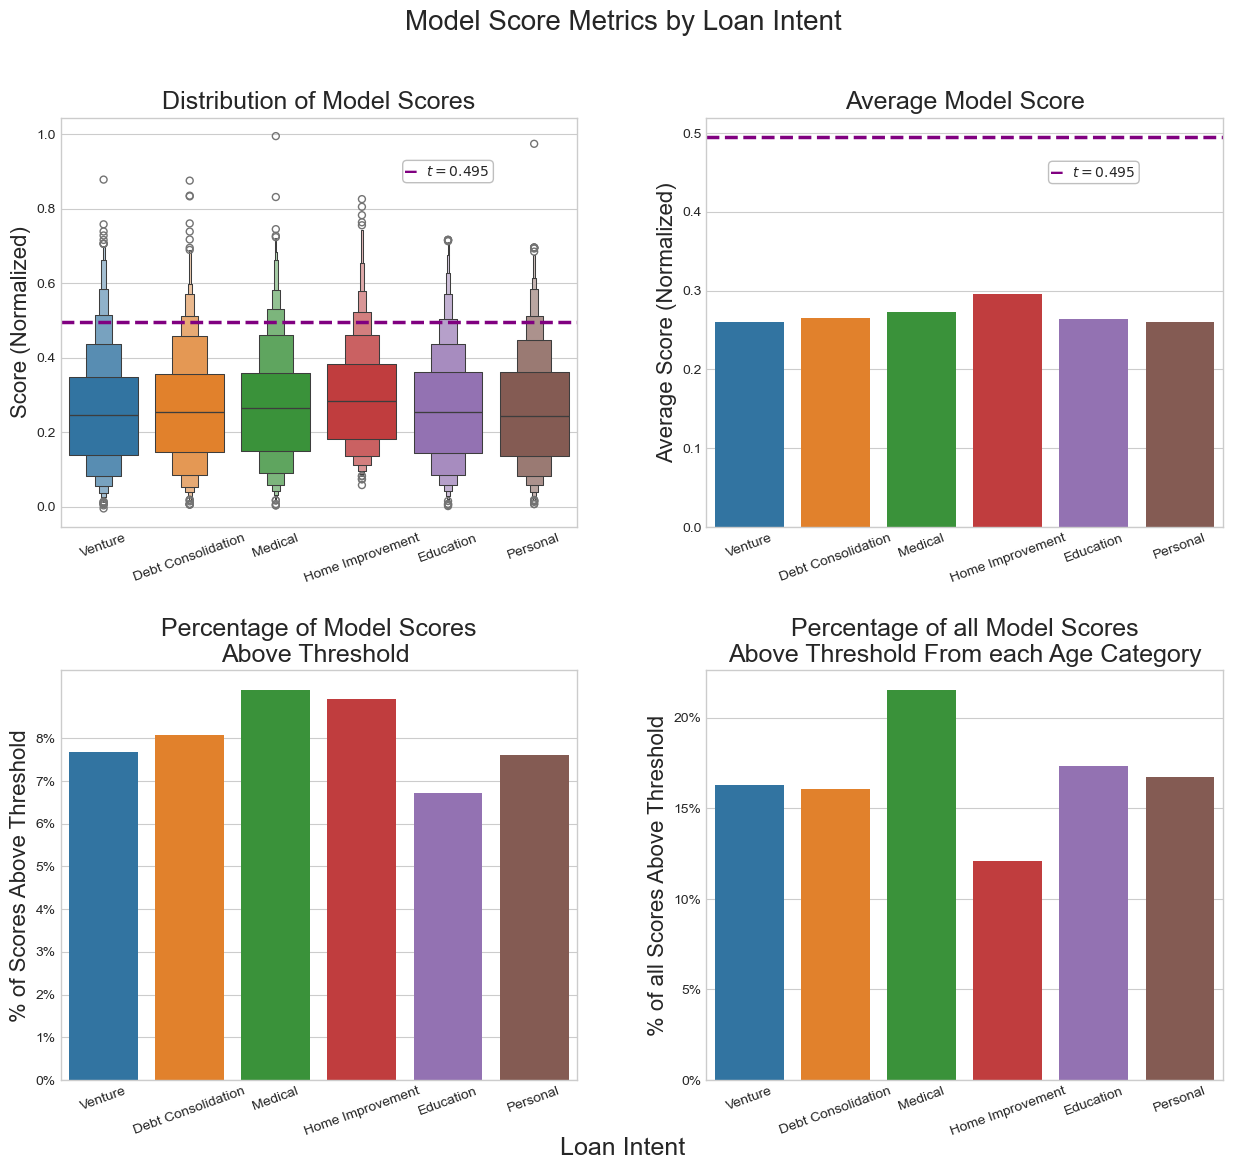

In [188]:
# Independent and dependent variables for bar chart
test["loan_intent"] = test["loan_intent"].map(loan_intent_recode)
loan_intents = np.array(test["loan_intent"].unique())
print(loan_intents)

# Avg. scores calculated using .groupby(...).aggregate(...)
li_avg_scores = np.array([
    test[test["loan_intent"] == "Venture"]["score"].mean(),
    test[test["loan_intent"] == "Debt Consolidation"]["score"].mean(),
    test[test["loan_intent"] == "Medical"]["score"].mean(),
    test[test["loan_intent"] == "Home Improvement"]["score"].mean(),
    test[test["loan_intent"] == "Education"]["score"].mean(),
    test[test["loan_intent"] == "Personal"]["score"].mean()
])
li_scores_df = pd.DataFrame({"Loan Intent": loan_intents, "Avg Score": li_avg_scores})

# Arrays of percentage of high scores and percentage of all scores above the threshold from each loan intent
li_perc_high_scores_1 = np.zeros(0)
li_perc_high_scores_2 = np.zeros(0)

for loan in loan_intents:
    
    # Calculating each metric
    li_perc_high_score_1 = (test[test["loan_intent"] == loan]["score"] >= best_threshold).mean() * 100
    li_perc_high_score_2 = ((test[test["loan_intent"] == loan]["score"] >= best_threshold).sum() / num_high_scores) * 100

    # Adding each metric to corresponding array
    li_perc_high_scores_1 = np.append(li_perc_high_scores_1, li_perc_high_score_1)
    li_perc_high_scores_2 = np.append(li_perc_high_scores_2, li_perc_high_score_2)

# Displaying average model score for each age cat
fig, ax = plt.subplots(2, 2, figsize = (15, 12.5))
plt.style.use("seaborn-v0_8-whitegrid")

# Distribution of scores by age cat
sns.boxenplot(test, x = "loan_intent", y = "score", hue = "loan_intent", legend = False, ax = ax[0, 0])
ax[0, 0].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[0, 0].set_title("Distribution of Model Scores", fontsize = 18)
ax[0, 0].set_ylabel("Score (Normalized)", fontsize = 16)
ax[0, 0].set_xticks([0, 1, 2, 3, 4 ,5])
ax[0, 0].set_xticklabels(loan_intents, rotation = 20)
ax[0, 0].set_xlabel("")
ax[0, 0].text(4, 0.9, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0, 0].text(3.5, 0.9, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

# Average score by age cat
sns.barplot(x = loan_intents, y = li_avg_scores, data = li_scores_df, hue = loan_intents, legend = False, ax = ax[0, 1])
ax[0, 1].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[0, 1].set_title("Average Model Score", fontsize = 18)
ax[0, 1].set_ylabel("Average Score (Normalized)", fontsize = 16)
ax[0, 1].set_xticks([0, 1, 2, 3, 4, 5])
ax[0, 1].set_xticklabels(loan_intents, rotation = 20)
ax[0, 1].text(4, 0.45, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0, 1].text(3.5, 0.45, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

# Percentage of high scores (above threshold) for each age cat
sns.barplot(x = loan_intents, y = li_perc_high_scores_1, hue = loan_intents, legend = False, ax = ax[1, 0])
ax[1, 0].set_title("Percentage of Model Scores\nAbove Threshold ", fontsize = 18)
ax[1, 0].set_ylabel("% of Scores Above Threshold", fontsize = 16)
ax[1, 0].set_xticks([0, 1, 2, 3, 4, 5])
ax[1, 0].set_xticklabels(loan_intents, rotation = 20)
ax[1, 0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax[1, 0].set_yticklabels(["0%", "1%", "2%", "3%", "4%", "5%", "6%", "7%", "8%"])

# Percentage of all high scores (above threshold) from each age cat
sns.barplot(x = loan_intents, y = li_perc_high_scores_2, hue = loan_intents, legend = False, ax = ax[1, 1])
ax[1, 1].set_title("Percentage of all Model Scores\nAbove Threshold From each Age Category", fontsize = 18)
ax[1, 1].set_ylabel("% of all Scores Above Threshold", fontsize = 16)
ax[1, 1].set_xticks([0, 1, 2, 3, 4, 5])
ax[1, 1].set_xticklabels(loan_intents, rotation = 20)
ax[1, 1].set_yticks([0, 5, 10, 15, 20])
ax[1, 1].set_yticklabels(["0%", "5%", "10%", "15%", "20%"])

fig.text(0.5, 0.95, "Model Score Metrics by Loan Intent", ha = "center", fontsize = 20)
fig.text(0.5, 0.05, "Loan Intent", ha = "center", fontsize = 18)
plt.subplots_adjust(wspace = 0.25, hspace = 0.35)


# Computing true defualt rates for medical, venture, and educational loans
m = test[test["loan_intent"] == "Medical"].copy()
v = test[test["loan_intent"] == "Venture"].copy()
e = test[test["loan_intent"] == "Education"].copy()
d = test[test["loan_intent"] == "Debt Consolidation"].copy()
p = test[test["loan_intent"] == "Personal"].copy()
h = test[test["loan_intent"] == "Home Improvement"].copy()
true_default_rates = np.array([
    (m["loan_status"] == 1).mean(),
    (v["loan_status"] == 1).mean(),
    (e["loan_status"] == 1).mean(),
    (d["loan_status"] == 1).mean(),
    (p["loan_status"] == 1).mean(),
    (h["loan_status"] == 1).mean(),
])


*Code above constructs 4 plots to observe how the model score varies across loan intent.  The top two plots simply display the distribution of model scores and the average score for each loan intent.  The bottom two plots show the percentage of high model scores within each loan intent and the percentage of overall high model scores attributed to each loan intent (computed by taking the number of high model scores for each loan intent over the total number of high model scores).*

**Figure 8**

As shown in the figures above, the the general distribution and average model scores across each loan intent are considerably similar.  That is, it does not appear that any specific loan intents correspond to significantly high or low model scores.  However, as shown in the bottom right plot, the largest percentage of all high model scores (scores that advise the bank to deny a borrower a loan), is attributed to medical loans.  This may suggest that it is more difficult for borrowers to have medical loans approved.  The actual rate of default for medical loans in the test data is about $30\%$, which is the second highest default rate (nearly equal to that of debt consolidation loans).  Considering that medical loans make up the largest percentage of overall high model scores and have the highest true rate of default in the test data, it may be justified that the bank makes it more difficult for borrowers seeking these types of loans to be approved.

As for venture and educational loans, it appears that borrowers looking to take out these types of loans are similarly likely to be approved by the bank (they have very similar average model scores, percentage of high scores within themselves, and percentage makeups of the overall high model scores).  Additionally, both venture loans and educational loans have similar default rates in the test data of about $15\%$ and $17\%$ respectively.

#### Loan Approval and Borrower Income

/var/folders/6b/w3ctkkqx2blbjst8tmrbr9th0000gn/T/ipykernel_94500/1484491168.py:26: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data = high_inc, x = "person_income", y = "score", hue = "high_score", palette = ["darkorange", "purple"], legend = False, ax = ax[1])


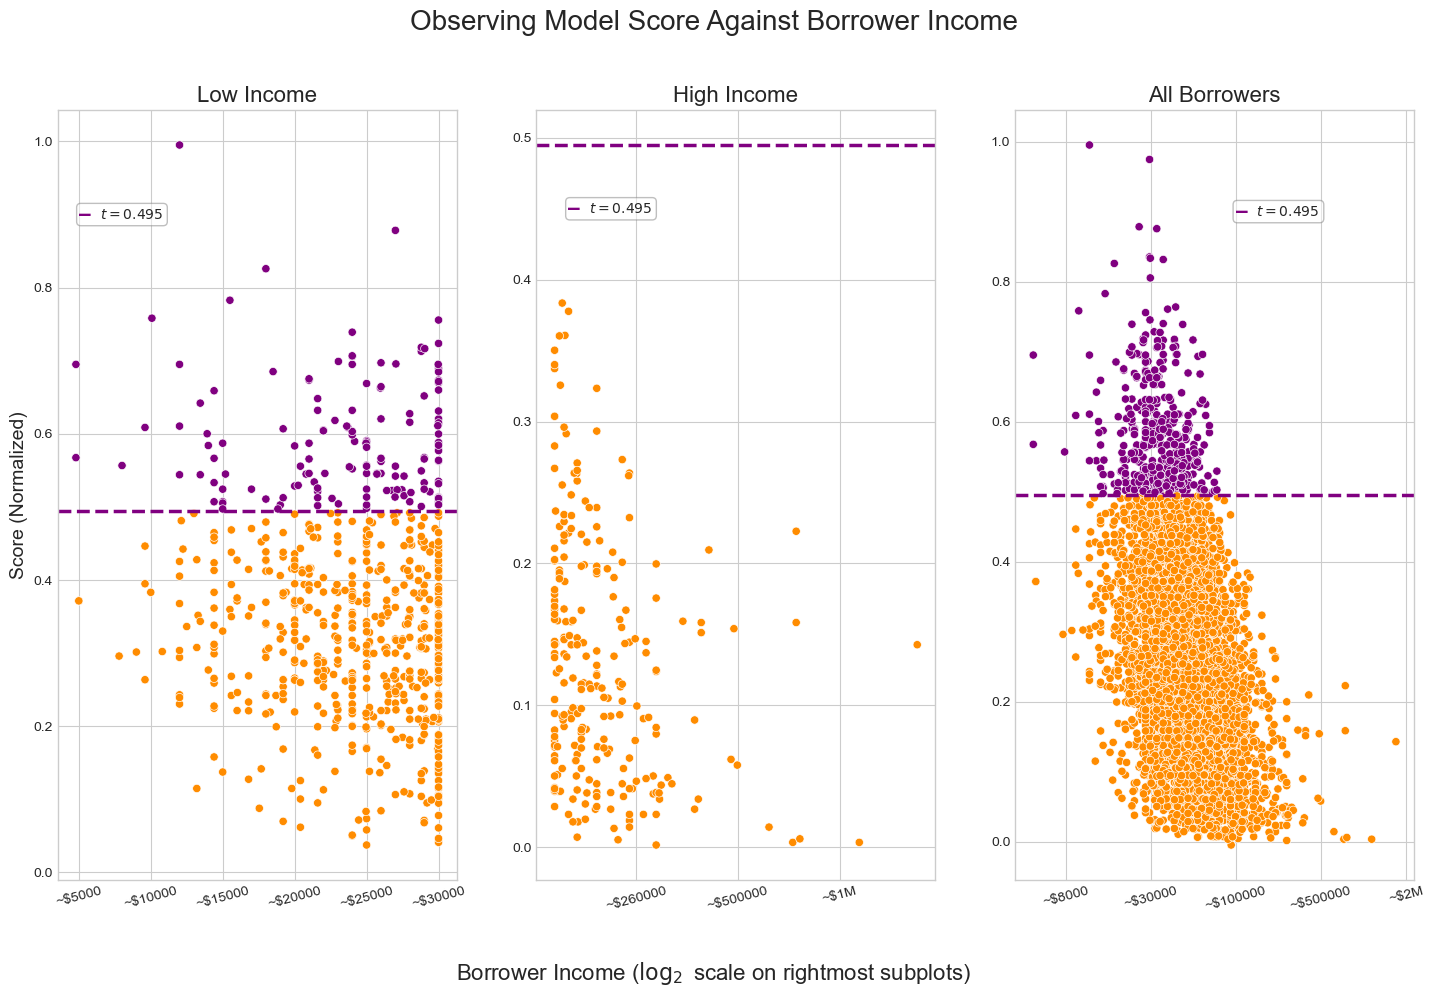

In [189]:
# Adding high/low score indicator col
test["high_score"] = test["score"] >= best_threshold
test["low_inc"] = (test["person_income"] <= 30000).astype(int)
test["high_inc"] = (test["person_income"] >= 150000).astype(int)
test["person_inc_log"] = np.log2(test["person_income"])

low_inc = test[test["low_inc"] == 1].copy()
high_inc = test[test["high_inc"] == 1].copy()

# Plotting model score against borrower income
fig, ax = plt.subplots(1, 3, figsize = (17.5, 10))

# Score by income for low income borrowers
sns.scatterplot(data = low_inc, x = "person_income", y = "score", hue = "high_score", palette = ["darkorange", "purple"], legend = False, ax = ax[0])
ax[0].set_title("Low Income", fontsize = 16)
ax[0].set_ylabel("Score (Normalized)", fontsize = 14)
ax[0].set_xlabel("")
ax[0].set_xticks([5e3, 10e3, 15e3, 20e3, 25e3, 30e3])
ax[0].set_xticklabels(["~$5000", "~$10000", "~$15000", "~$20000", "~$25000", "~$30000"], rotation = 15)
ax[0].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[0].text(8000, 0.9, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[0].text(5000, 0.9, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

# Score by income for high income borrowers
sns.scatterplot(data = high_inc, x = "person_income", y = "score", hue = "high_score", palette = ["darkorange", "purple"], legend = False, ax = ax[1])
ax[1].set_xscale("log", base = 2)
ax[1].set_title("High Income", fontsize = 16)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_xticks([2 ** 18, 2 ** 19, 2 ** 20])
ax[1].set_xticklabels(["~$260000", "~$500000", "~$1M"], rotation = 15)
ax[1].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[1].text(2 ** 17.75, 0.45, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[1].text(2 ** 17.325, 0.45, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

# Score by income for all borrowers
sns.scatterplot(data = test, x = "person_income", y = "score", hue = "high_score", palette = ["darkorange", "purple"], legend = False, ax = ax[2])
ax[2].set_xscale("log", base = 2)
ax[2].set_title("All Borrowers", fontsize = 16)
ax[2].set_ylabel("")
ax[2].set_xlabel("")
ax[2].set_xticks([2 ** 13, 2 ** 15, 2 ** 17, 2 ** 19, 2 ** 21])
ax[2].set_xticklabels(["~$8000", "~$30000", "~$100000", "~$500000", "~$2M"], rotation = 15)
ax[2].axhline(best_threshold, linestyle = "--", color = "purple", linewidth = 2.5)
ax[2].text(2 ** 18, 0.9, f"     $t = 0.495$", ha = "center", va = "center", fontsize = 10, 
        bbox = dict(facecolor = "white", alpha = 0.5, edgecolor = "gray", boxstyle = "round,pad=0.3"))
ax[2].text(2 ** 17, 0.9, "\u2013", color = "purple", ha = "left", va = "center", fontsize = 15, fontweight="bold")

fig.suptitle("Observing Model Score Against Borrower Income", fontsize = 20)
fig.text(0.5, 0.01, "Borrower Income ($\log_2$ scale on rightmost subplots)", ha = "center", fontsize = 16)

plt.show()

# Calculating default rates for low and high income borrowers
true_default_rates_inc = np.array([
    (low_inc["loan_status"] == 1).mean(),
    (high_inc["loan_status"] == 1).mean()
])

*Code above constructs scatter plots observing model score by borrower income for low-income borrowers, high-income borrowers, and all borrowers.  The threshold is included in each plot to depict where the score cutoff is.*

**Figure 9**

As depicted in the plots above, there seems to be a general trend between borrower income and their corresponding model score.  That is, it appears that as a borrower's income increases, their score decreases.  This may suggest that the model makes it easier for higher-income individuals to be approved for loans than those at lower-income levels.  This is supported by the fact that a considerable proportion of low-income borrowers ($\leq \$30000$ annual earnings) were scored above the threshold (i.e. likely not approved) while none of the high-income borrowers ($\geq \$150000$ annual earnings) were scored above the threshold.  This may be sufficient evidence for the bank, but it is important to note that a borrower's income is not actually one of the features the model was trained on.  Thus, this observation may be due to other related factors.

# Discussion

The goal of this study was to experiment with the construction of an automated decision model for a binary decision circumstance, and to examine how this model classified the data based on its various features.  At a higher level, this study allowed me to gain some hands-on experience tweaking and interpreting the characteristics of a completely automated classification model.  This has provided me with a fulfilling opportunity to investigate how models sculpt their decision-making parameters based both on the data and the intentions of the model designer -- Ultimately exploring how this model might treat people (data observations) with different relevant (or irrelevant) qualities to the decision-making task.  While conducting this analysis, I had the opportunity to deepen my understanding of feature selection processes for model training, designing a scoring function, establishing a threshold to maximize certain values, and using a model to develop understandings of how it treats unseen data.

As described in the sections above, some of the most notable results from this study include: 1. The model appears to make loan approval easier for younger borrowers as opposed to older ones; 2. Out of all loan intents, the model makes it most difficult for borrowers seeking medical loans to get approval; 3. The model seems to make it easier for higher-income borrowers to be approved for loans than those of lower-income.  As far as "fairness" with this model is concerned.  I feel that there are two reasonable and opposing arguments to be made regarding the actions hypothetical bank based on using the model from this study.  Firstly, it is important to note that the model is designed from the perspective of the bank and thus aims at achieving the ultimate goal of maximizing the bank's interests (seemingly profit-per-borrower).  With this in mind, the model seems to make loan approval more difficult for lower-income borrowers and or borrowers seeking medical loans while the default rates for each of these categories are highest (or at least nearly so) among their respective groups.  In this sense, the model behaves logically and arguably "fairly".  E.g: Sure, medical loans are less likely to be repaid, so it's reasonable to make them harder to approve.  However, this behavior of the model allows for impactful and harmful decisions to be made upon certain individuals without taking into account the vast collection of reasons why these borrowers are considered more "risky" by the model.  Personally, I think the most useful model is one that is designed to be used by the bank but with the intentions of assisting the borrower.  That is, I would argue that this model should have some sort of "loan severity" parameter that provides information about the necessity of a given loan.  With such a parameter in place, a borrower's low-income status, higher age, or medical matters need not necessarily withhold them from financial assistance that would otherwise be given to more fortunate borrowers looking to make personal or business advancements.  Considering this other approach, I would define "fairness" in this context as the model making decisions about loan approval with some sort of information pertaining to the loan necessity for a given borrower.  That is, the model would decide loan approval based on both financial and need-based characteristics of borrowers.  Until the model operates under these or similar conditions, I personally feel that it is not particularly "fair".

Above all, the question of "fairness" exercised by the model in this study extends to the larger concept of ethical machine learning.  Forming a strict definition of fairness is rarely easy and often not intuitive in the context of many applications of ML models and algorithms.  Yet, it will always remain a crucial part of ML model and algorithm design to deeply consider how fairness bears significance in a given ML application, especially when systemic biases and injustices may be at play.

*During the implementation process of this blog post, I collaborated with Andrew Dean.*